In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gc


from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

sys.path.append('../dataset_construction')
sys.path.append('../../util')
from pano_utils import *
import panoseti_file_interfaces as pfi

In [2]:
data_dir = '/Users/nico/Downloads/panoseti_test_data/obs_data/data'
# run_dir = 'obs_Lick.start_2023-08-01T05:14:21Z.runtype_sci-obs.pffd'
run_dir = 'obs_Lick.start_2023-08-29T04:49:58Z.runtype_sci-obs.pffd'


def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df

In [3]:
ori = pfi.ObservingRunInterface(data_dir, run_dir)

In [4]:
ori.obs_pff_files

{254: {'img': [],
  'ph': [{'fname': 'start_2023-08-29T04_50_46Z.dp_ph256.bpp_2.module_254.seqno_0.pff',
    'seqno': 0,
    'nframes': 12659,
    'first_unix_t': 1693284653.7706468,
    'last_unix_t': 1693295935.3568306}]},
 1: {'img': [{'fname': 'start_2023-08-29T04_50_49Z.dp_img16.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 1574804,
    'first_unix_t': 1693284655.2144074,
    'last_unix_t': 1693284812.6947074},
   {'fname': 'start_2023-08-29T04_53_33Z.dp_img16.bpp_2.module_1.seqno_1.pff',
    'seqno': 1,
    'nframes': 1574804,
    'first_unix_t': 1693284812.6948075,
    'last_unix_t': 1693284970.1751075}],
  'ph': [{'fname': 'start_2023-08-29T04_50_49Z.dp_ph256.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 10519,
    'first_unix_t': 1693284655.602064,
    'last_unix_t': 1693295937.1693113}]},
 3: {'img': [],
  'ph': [{'fname': 'start_2023-08-29T04_50_49Z.dp_ph256.bpp_2.module_3.seqno_0.pff',
    'seqno': 0,
    'nframes': 12822,
    'first_unix_t': 169

In [6]:
def plot_img(data, cbar=False, ax=None, vmin=-50, vmax=50, cmap='rocket'):
    div = 1 / np.sqrt(abs(data))
    div = np.nan_to_num(div, nan=1)
    
    if ax:
        im_orig = ax.imshow(
            data * div, vmin=vmin, vmax=vmax, cmap=cmap,
        )
    else:
        im_orig = plt.imshow(
            data *  div, vmin=vmin, vmax=vmax, cmap='rocket'#cmap='crest_r',
        )
    if cbar:
        cbar_orig = plt.colorbar(im_orig, label='Counts', fraction=0.046, location='right')
    plt.axis('off')

In [7]:
def plot_grid(imgs, title, cols=10, rows_per_plot=10, vmin=-100, vmax=100, cmap='rocket'):
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    title_added = False
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                plot_img(img, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
                if not title_added:
                    ax.set_title(title)
                    title_added = True
        plt.show()
        plt.close()

In [8]:
?ori.stack_frames

Signature:
ori.stack_frames(
    start_file_idx,
    start_frame_offset,
    module_id,
    stacked_integration_usec=12000,
    agg='mean',
    allow_partial_image=False,
)
Docstring:
Stacks consecutive imaging frames until the cumulative imaging time equals stacked_integration_usec.
    1) Evenly samples image frames between the start frame, specified by start_file_idx and start_frame_offset, and
    the frame with timestamp now - stacked_integration_ussec.
    2) Then aggregates the frames according to the agg procedure ['sum', 'mean'].

By default, stack until a total of 6ms of observational data is accumulated. e.g.:
- For a 100us integration time, add 60 images together.
- For a 2000us integration time, add 3 images together.

@param start_file_idx: sequence number of PFF imaging file in which frame sampling should begin.
@param start_frame_offset: frame offset within the specified file, relative to the earliest frame in this file.
@param stacked_integration_usec: total duration o

{'quabo_0': {'pkt_num': 26576, 'pkt_tai': 340, 'pkt_nsec': 214407488, 'tv_sec': 1693284655, 'tv_usec': 764942}, 'quabo_1': {'pkt_num': 19218, 'pkt_tai': 340, 'pkt_nsec': 214407484, 'tv_sec': 1693284655, 'tv_usec': 764943}, 'quabo_2': {'pkt_num': 10888, 'pkt_tai': 340, 'pkt_nsec': 214407488, 'tv_sec': 1693284655, 'tv_usec': 764945}, 'quabo_3': {'pkt_num': 2935, 'pkt_tai': 340, 'pkt_nsec': 214407492, 'tv_sec': 1693284655, 'tv_usec': 764947}}


/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

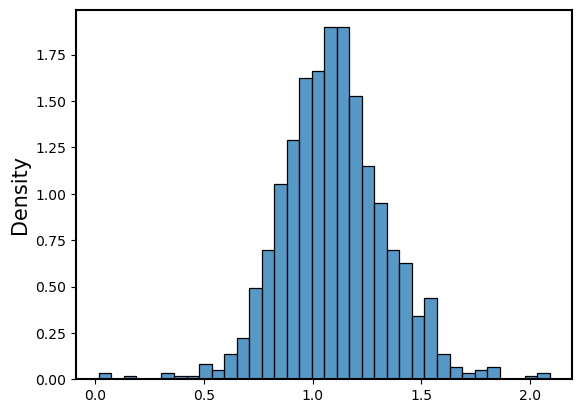

In [18]:
img, stacked_meta = ori.stack_frames(0, 0, 1, stacked_integration_usec=12e3, agg='mean')
# plot_img(img, vmin=10, vmax=15, cmap='rocket')
sns.histplot(
    img.ravel(),
    stat='density',
    label='pixel_stats',
)

In [20]:
stacked_meta

{'start_unix_t': -1,
 'end_unix_t': Decimal('1693284655.214407488'),
 'nframes': 120,
 'stacked_integration_usec': 12000.0}

done


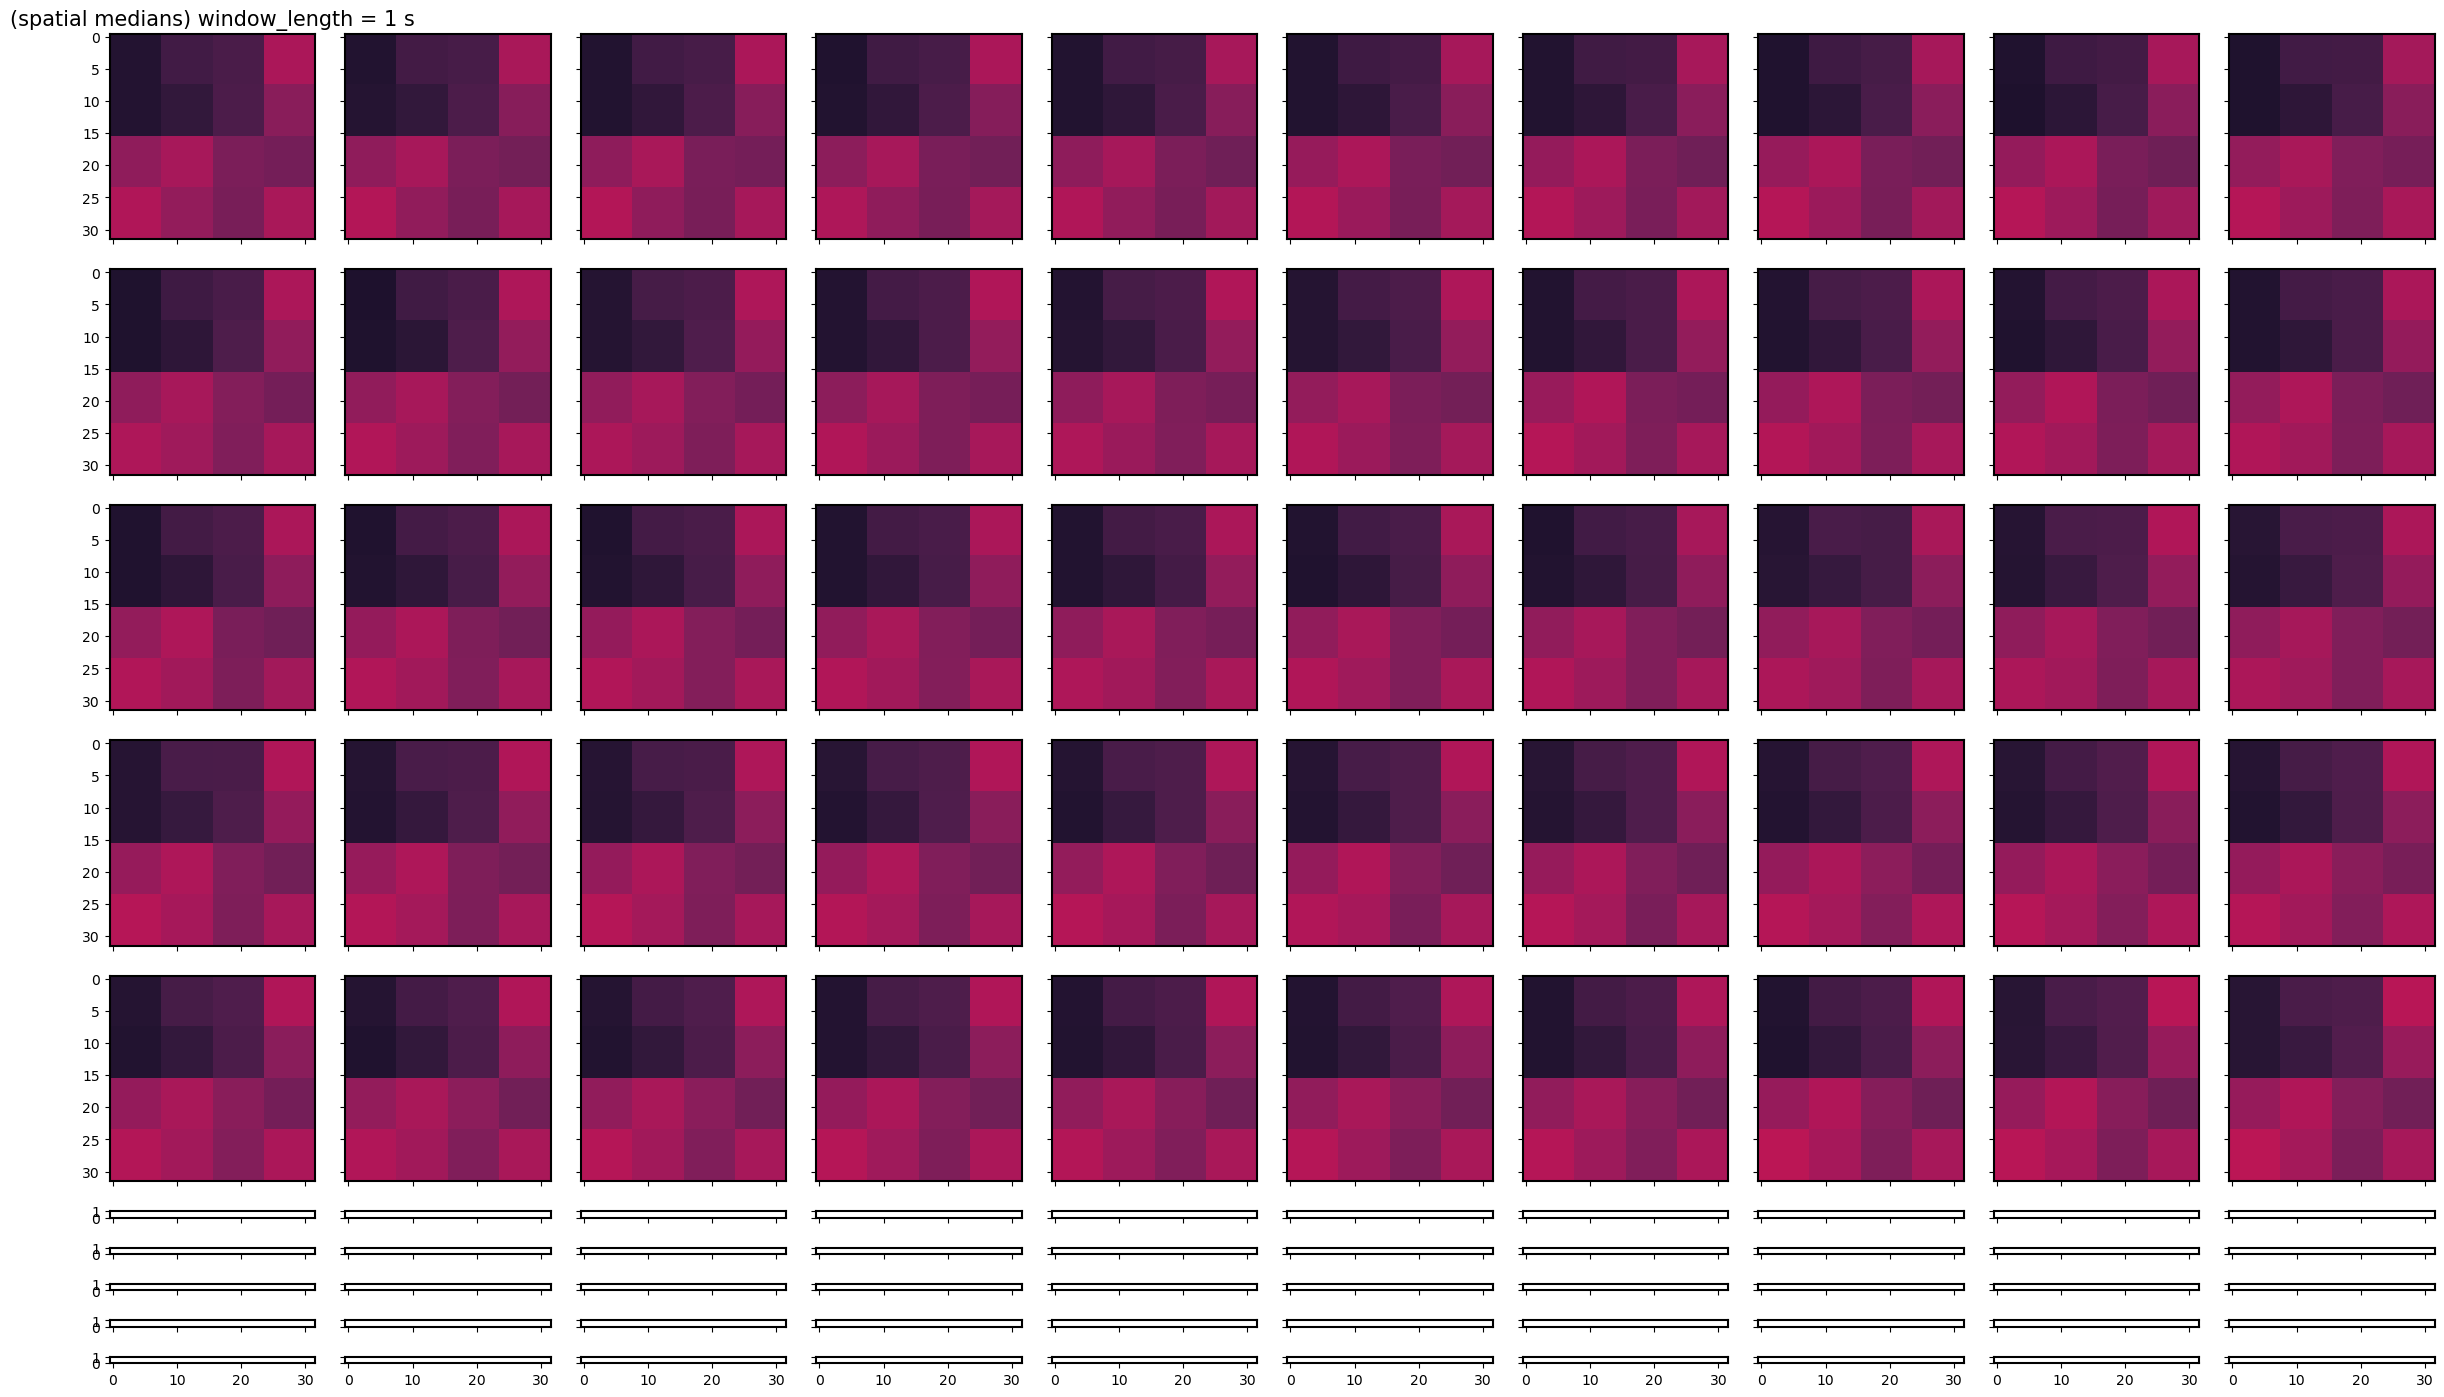

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_31096/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


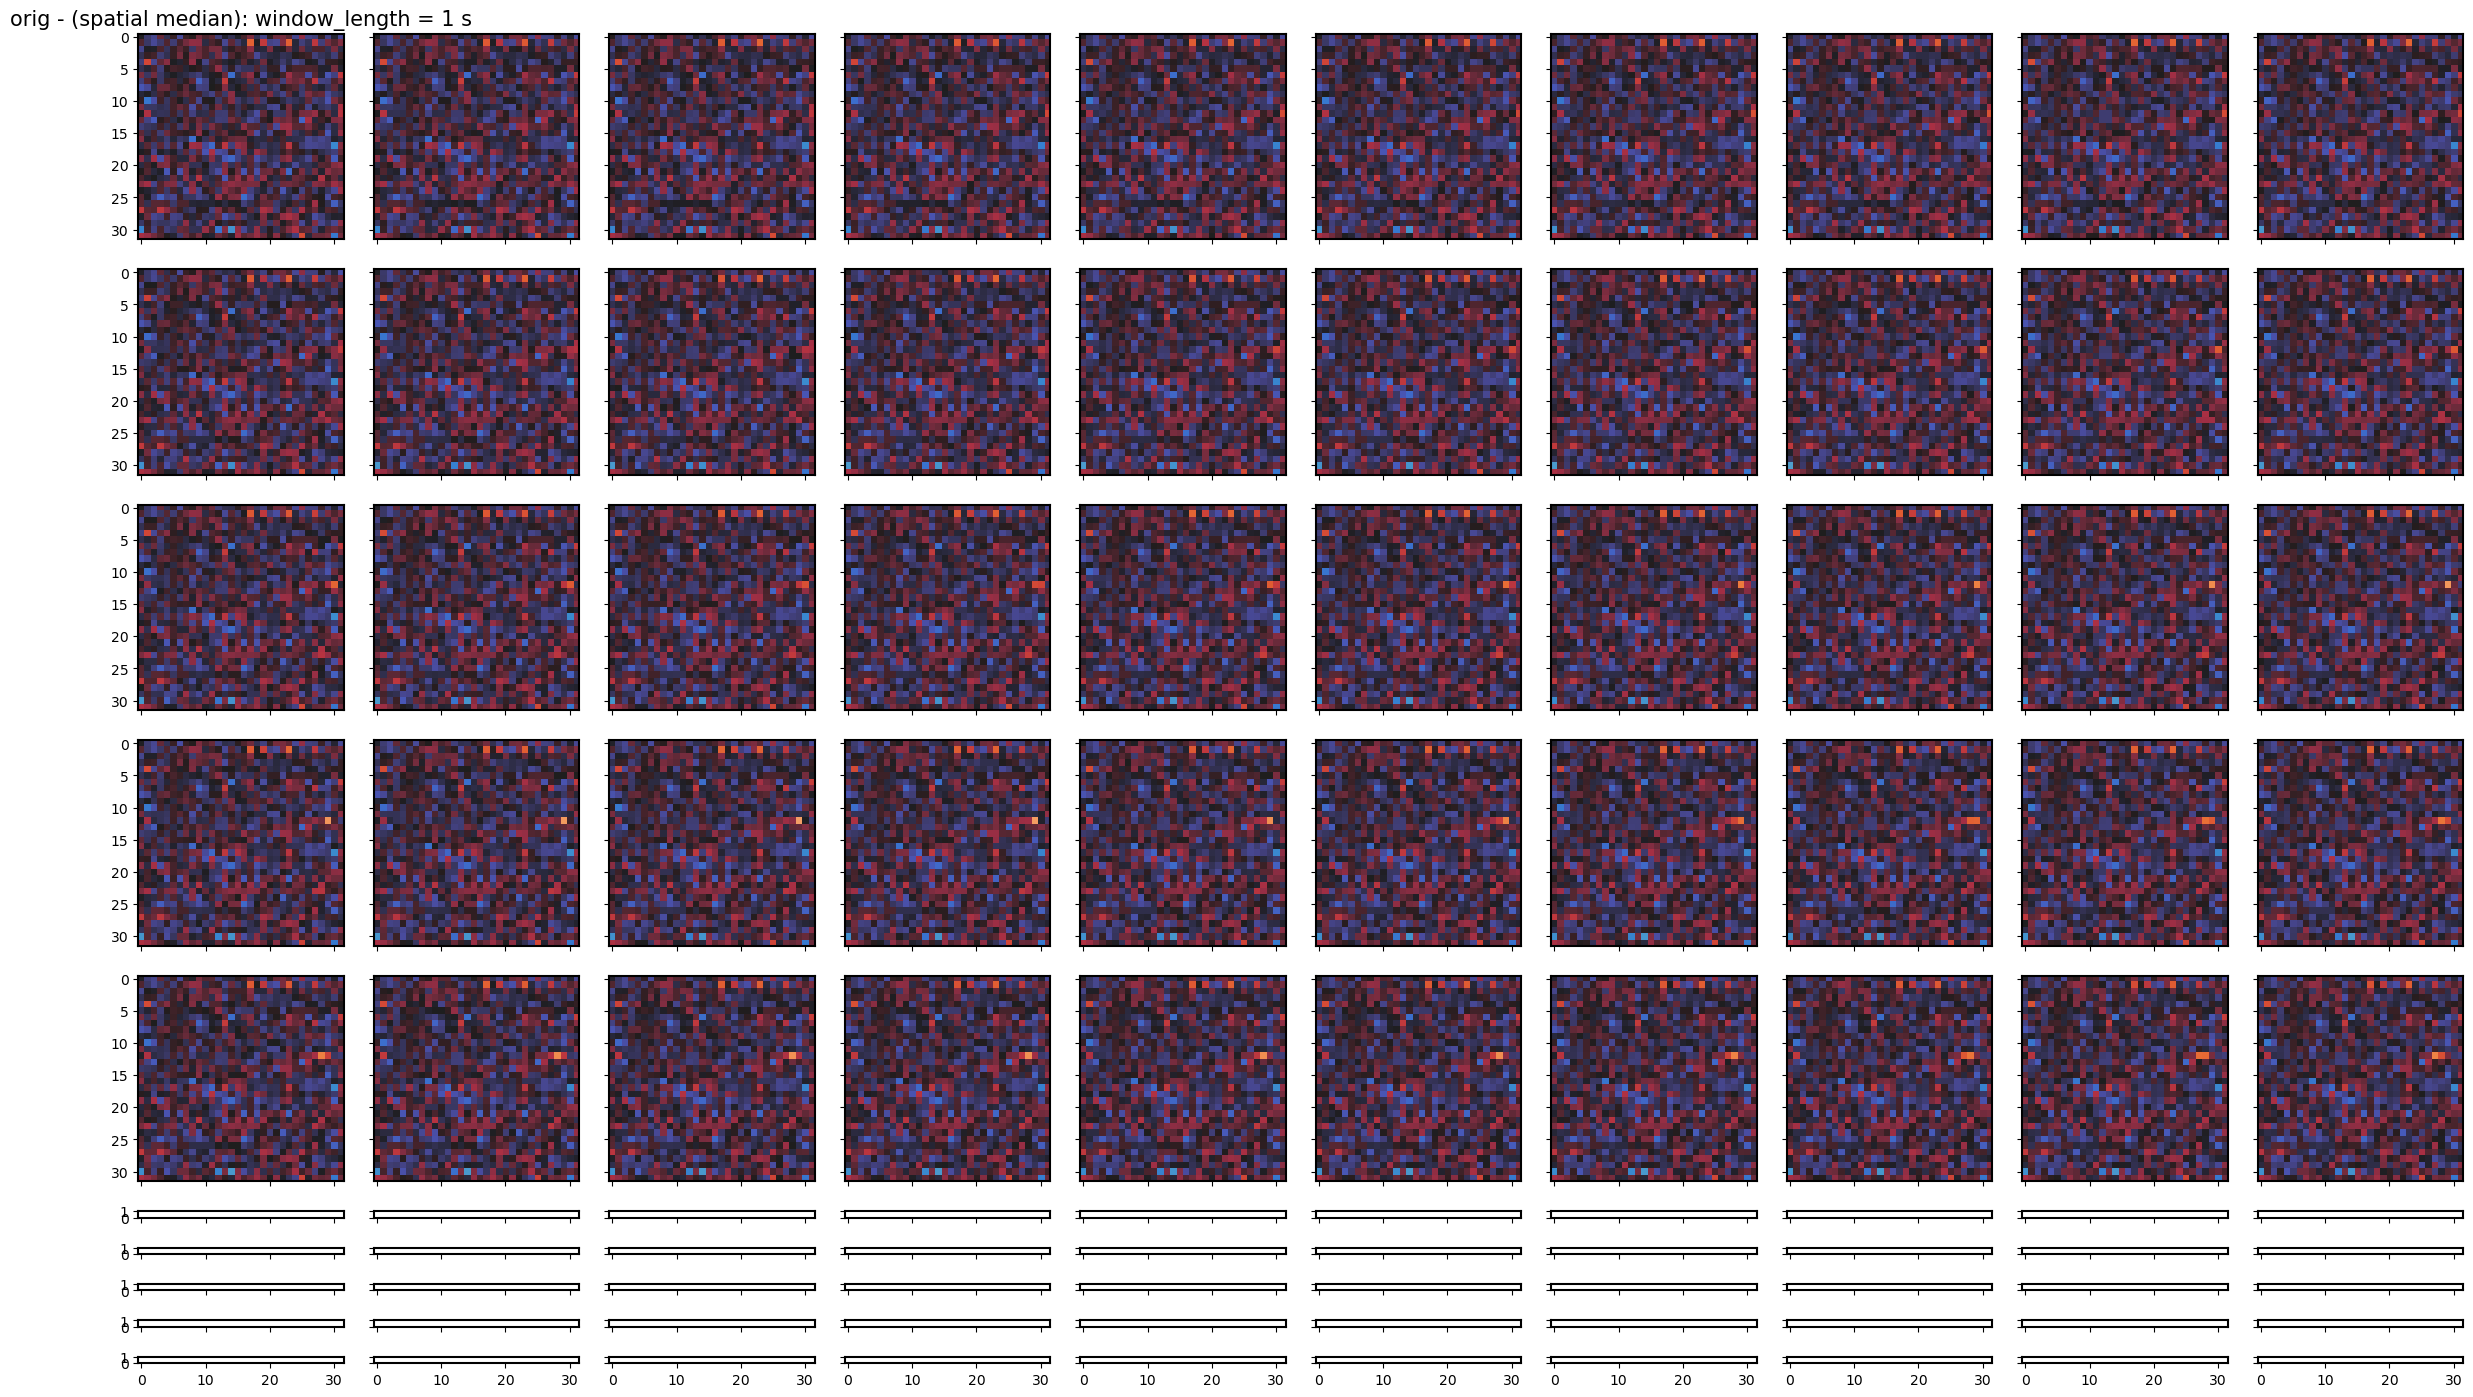

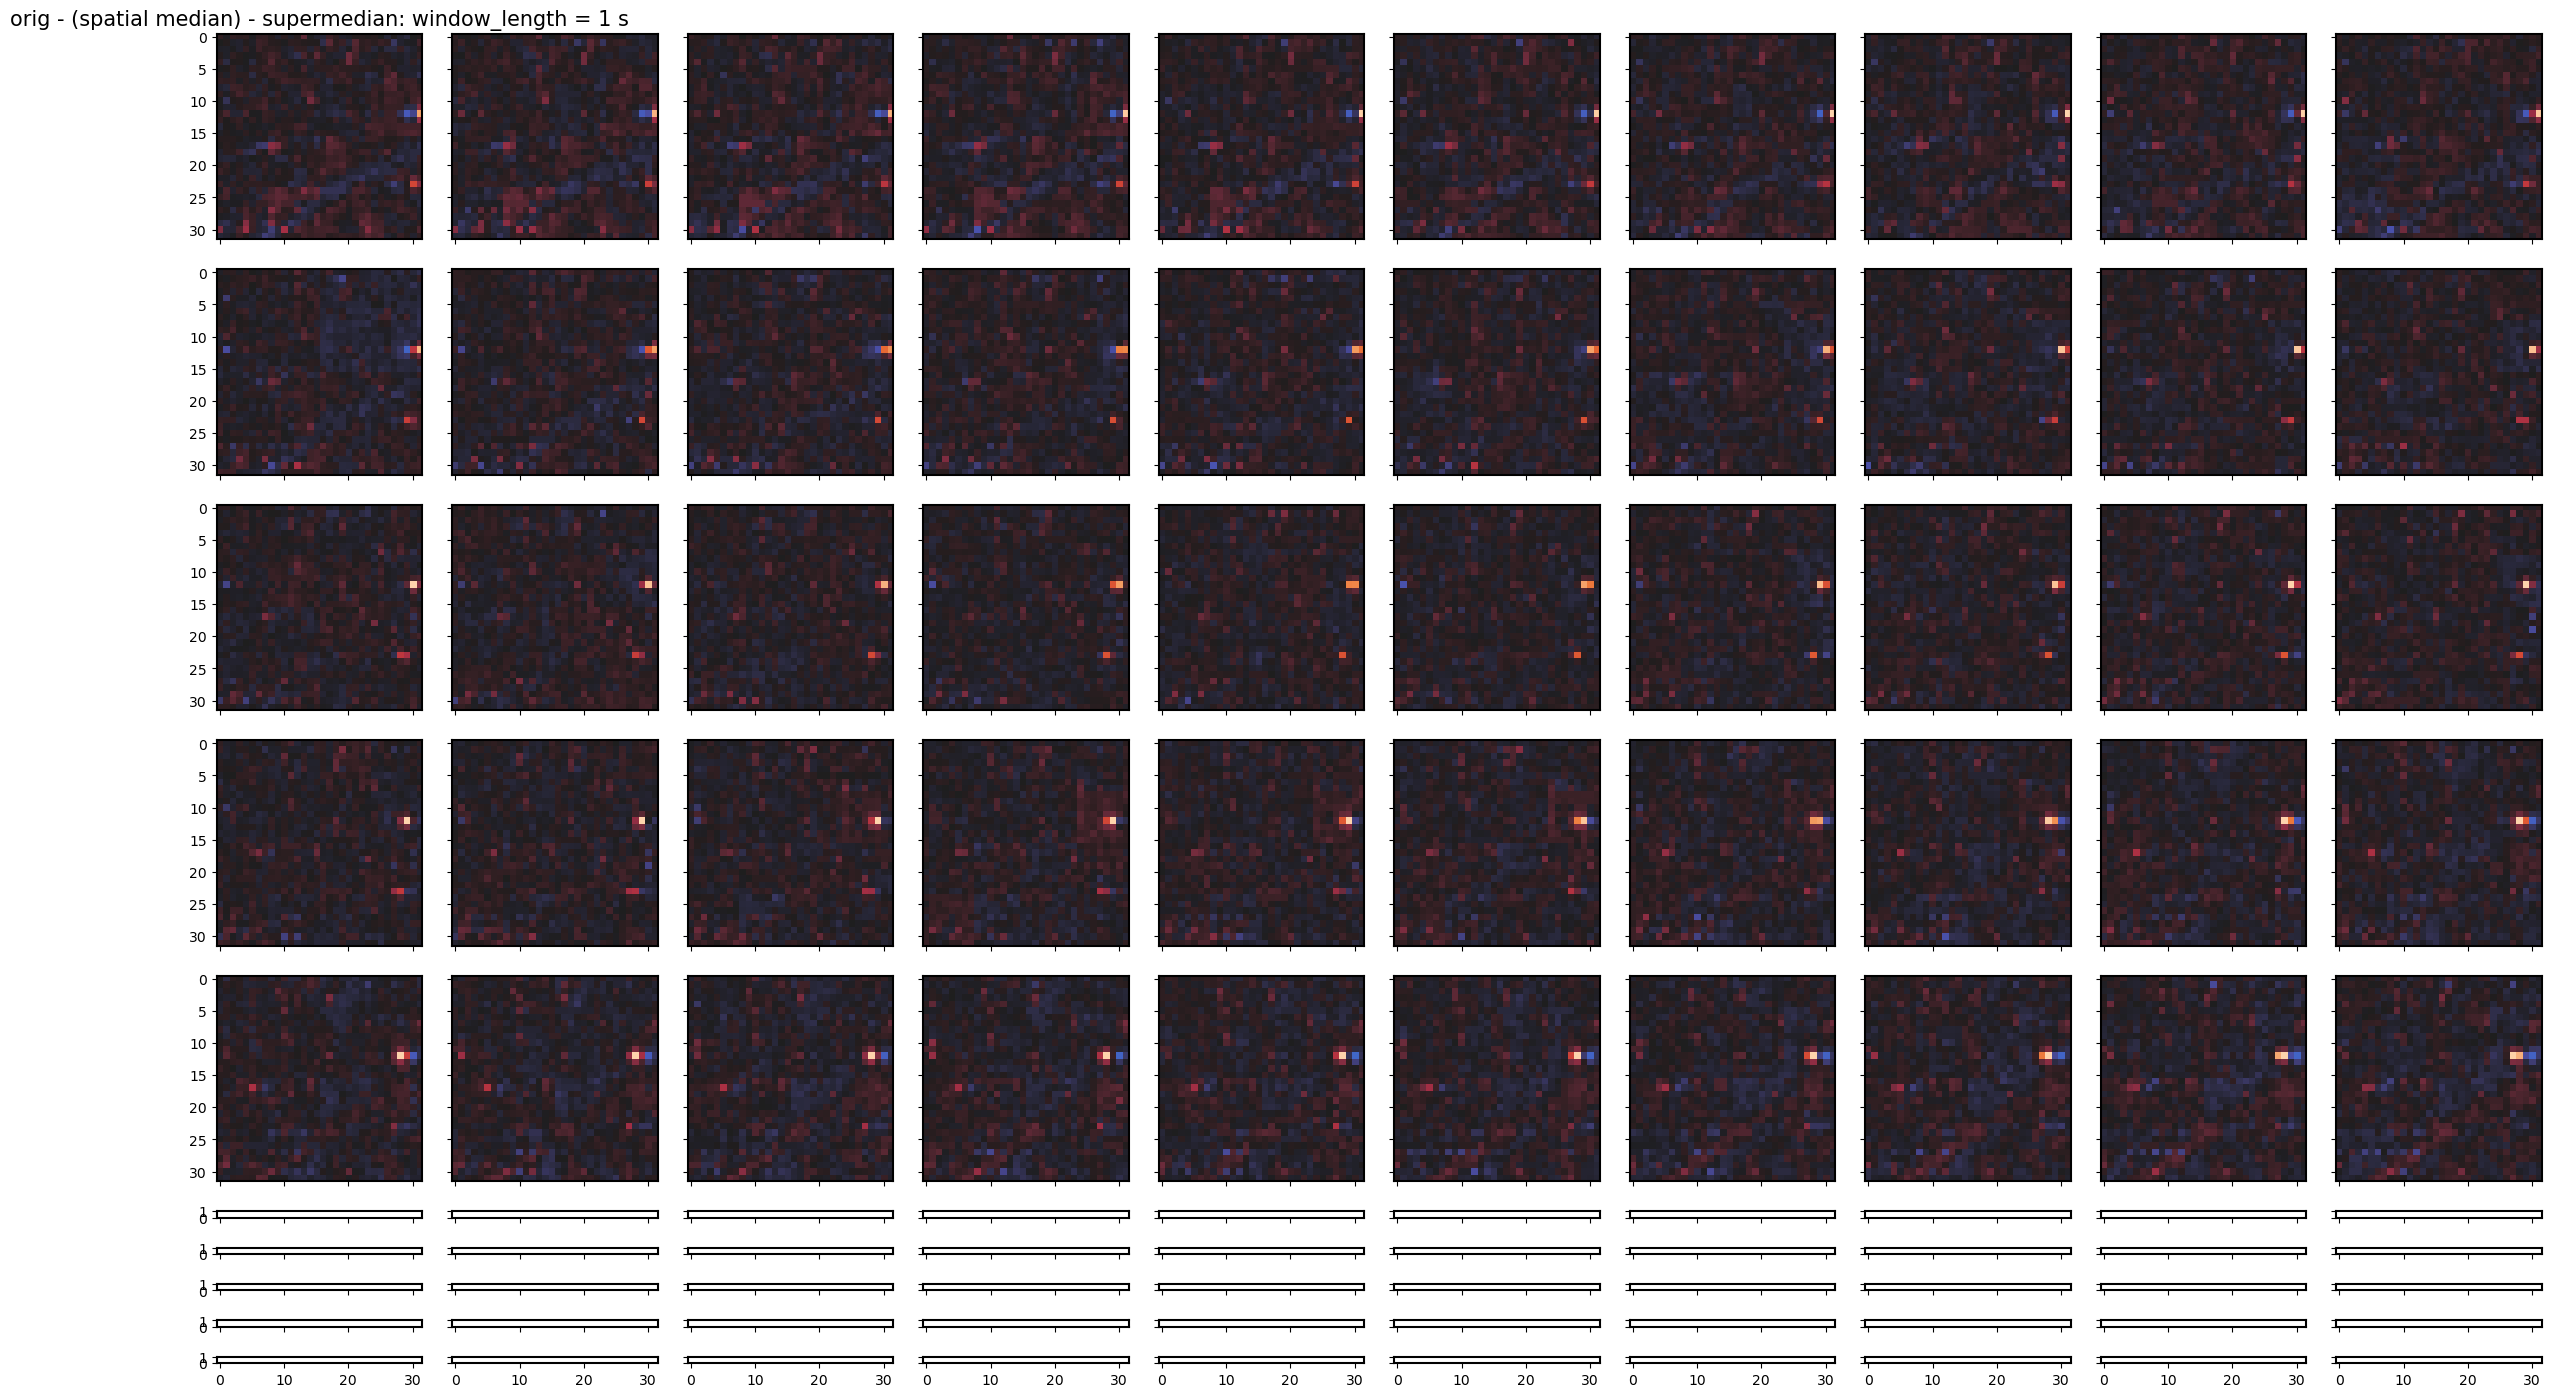

In [30]:
np.random.seed(50)
module_id = 1
for k in [1]:
    spatial_medians, buffer, buffer_no_spatial_medians, supermedian, flat, spdf = ori.compute_module_supermedian_image(
        module_id, spatial_median_window_usec=k*10**6, max_samples_per_window = 10
    )
    sm_idxs = np.linspace(0, len(spatial_medians) - 1, 50).astype(int)
    bf_idxs = np.linspace(0, len(buffer) - 1, 50).astype(int)
    bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 50).astype(int)
    flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
    print('done')
    plot_grid(spatial_medians[sm_idxs, :, :], f'(spatial medians) window_length = {k} s', vmin=10, vmax=15)
    # plot_grid(buffer[bf_idxs, :, :], f'(original) window_length = {k} s', vmin=10, vmax=15)
    plot_grid(buffer_no_spatial_medians[bfnsm_idxs, :, :], f'orig - (spatial median): window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')
    plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

In [31]:
spdf

,window_left_unix_t,window_right_unix_t,spatial_median_img,spatial_median+supermedian
0,1693284655.214407488,1693284656.126307488,"[[109.7125, 109.7125, 109.7125, 109.7125, 109....",NaN
1,1693284656.214407488,1693284657.126307488,"[[109.97083333333333, 109.97083333333333, 109....",NaN
2,1693284657.214407488,1693284658.126307488,"[[110.19583333333333, 110.19583333333333, 110....",NaN
3,1693284658.214407488,1693284659.126307488,"[[109.96666666666667, 109.96666666666667, 109....",NaN
4,1693284659.214407488,1693284660.126307488,"[[109.625, 109.625, 109.625, 109.625, 109.625,...",NaN
...,...,...,...,...
310,1693284965.214407488,1693284966.126307488,"[[111.20416666666667, 111.20416666666667, 111....",NaN
311,1693284966.214407488,1693284967.126307488,"[[111.17083333333333, 111.17083333333333, 111....",NaN
312,1693284967.214407488,1693284968.126307488,"[[111.55, 111.55, 111.55, 111.55, 111.55, 111....",NaN
313,1693284968.214407488,1693284969.126307488,"[[111.34583333333333, 111.34583333333333, 111....",NaN


In [28]:
x = np.zeros((5, 32, 32))
len(x)

5

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_27162/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


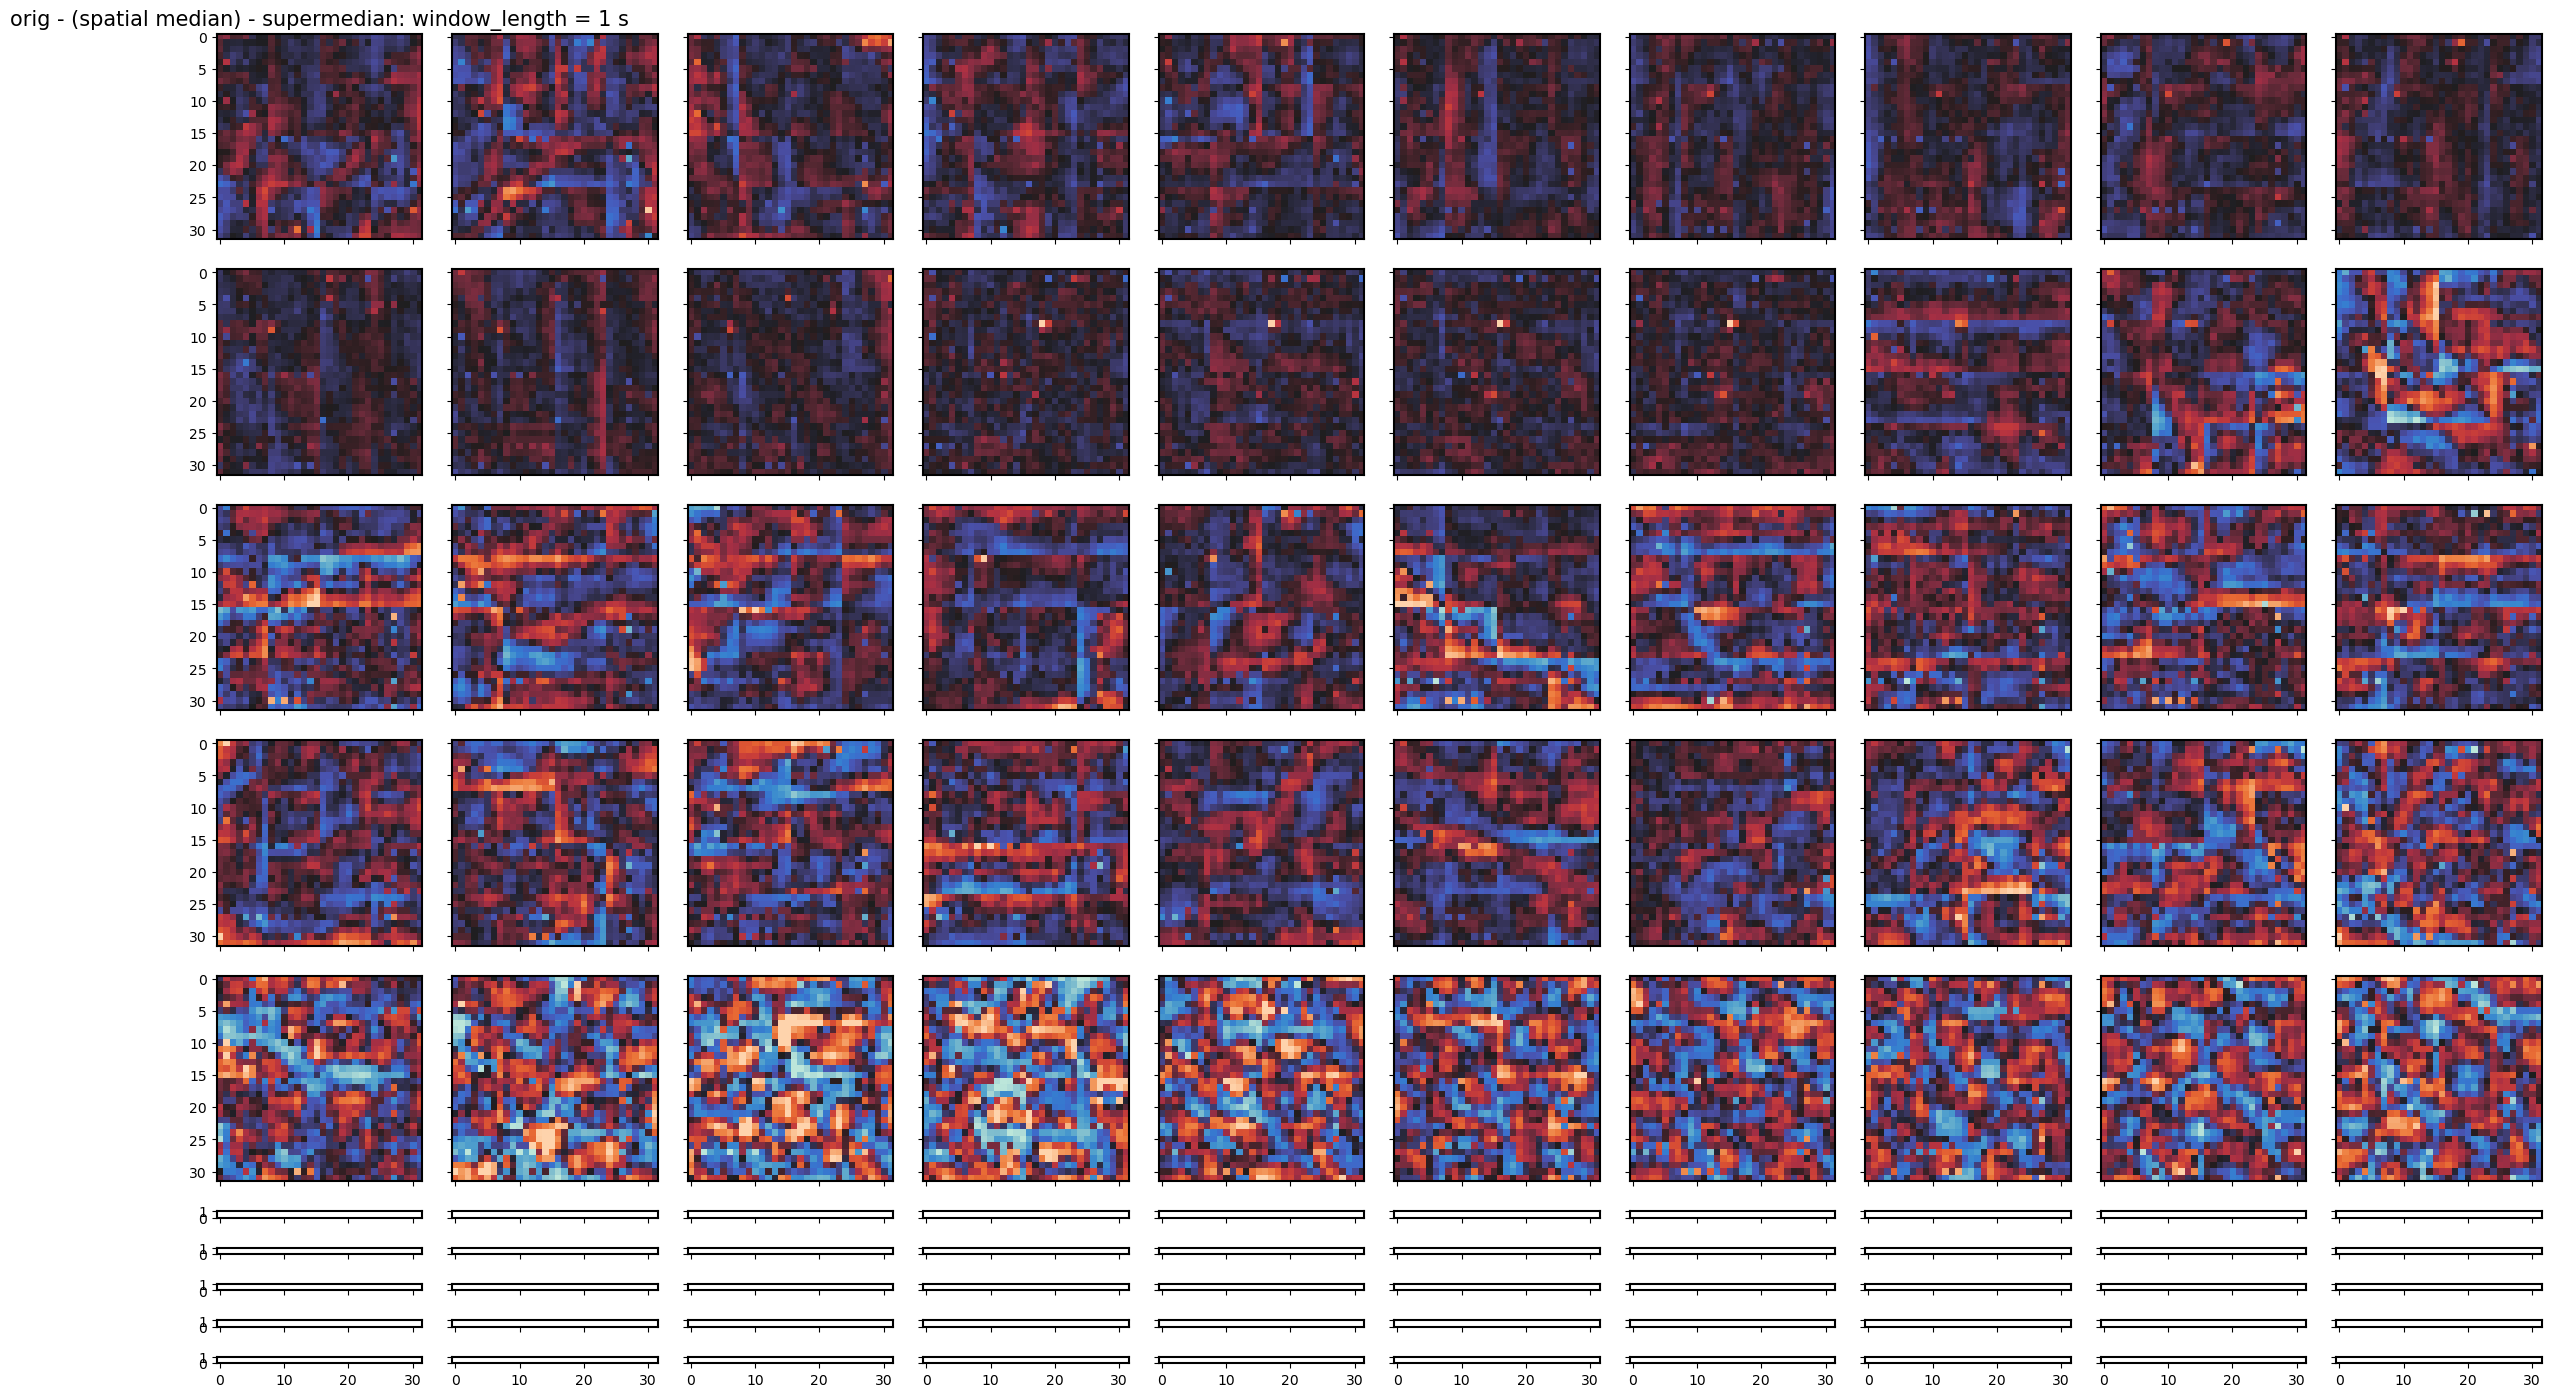

In [255]:
# nstack = 1
# flat_stacked = np.sum(
#     (buffer - supermedian * 2).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:])),
#     axis=0
# )
flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

In [256]:
(nstack * ori.intgrn_usec / 1e6) * 60000

6.0

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_27162/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


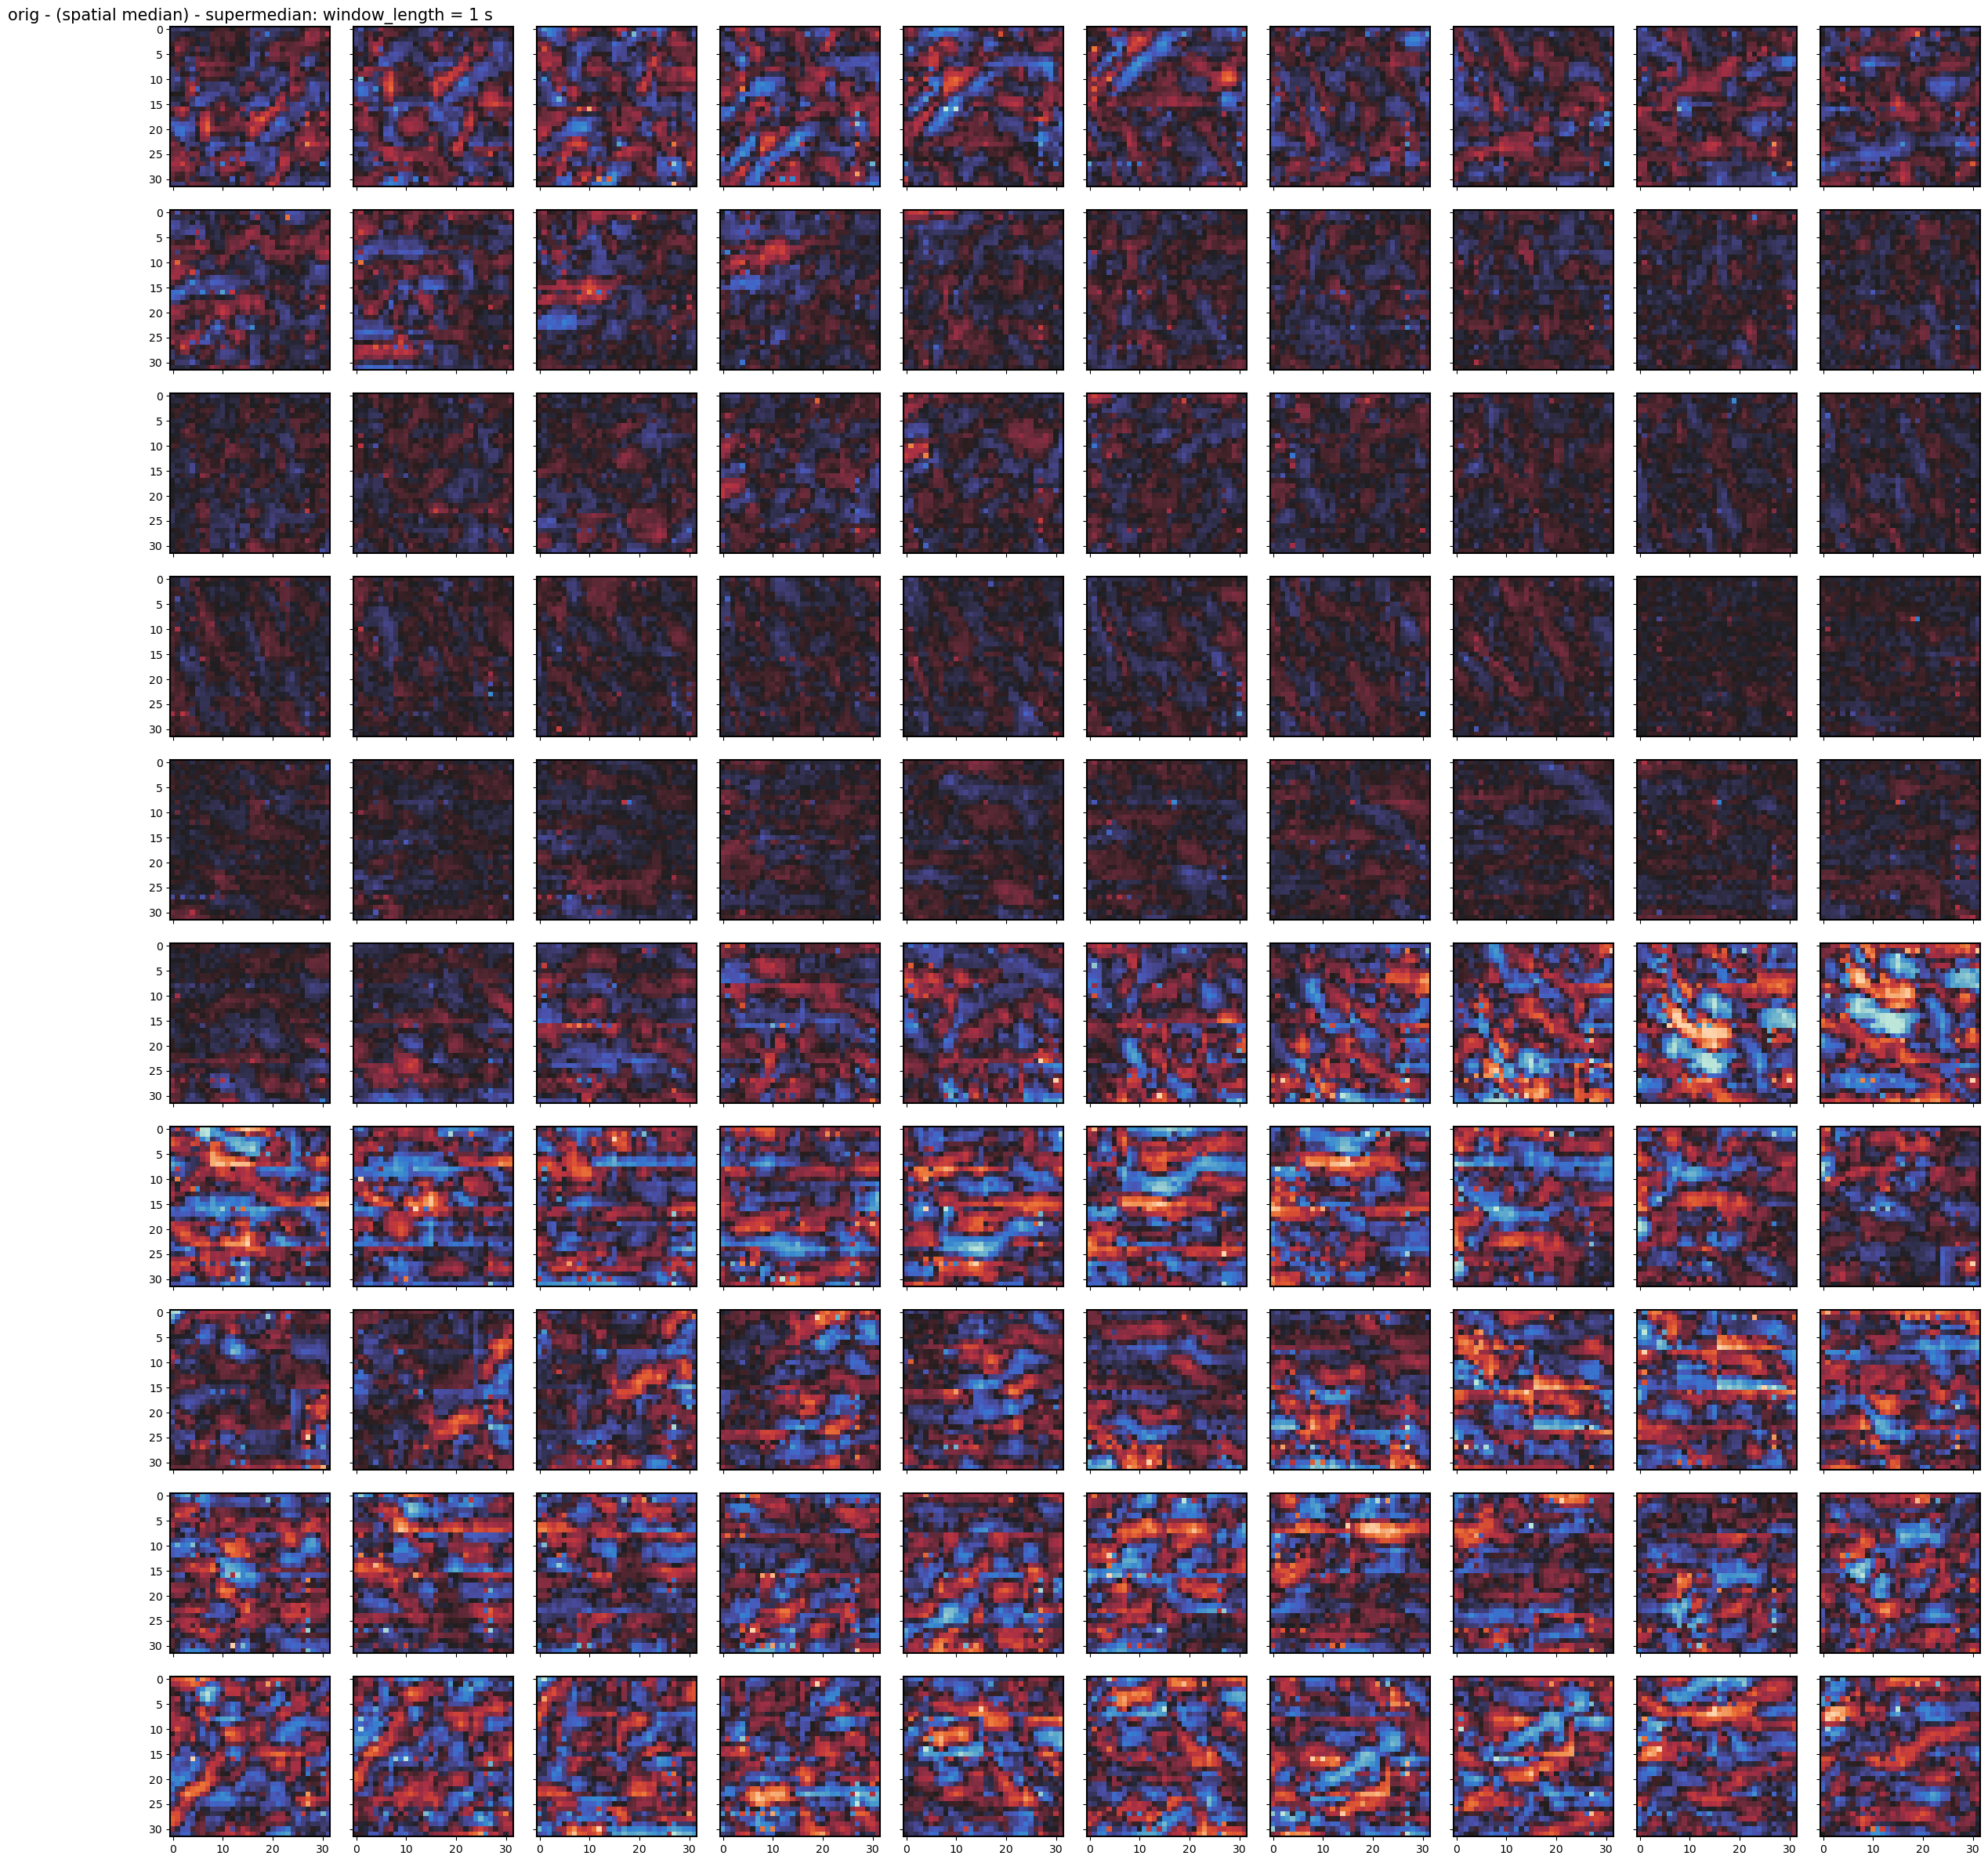

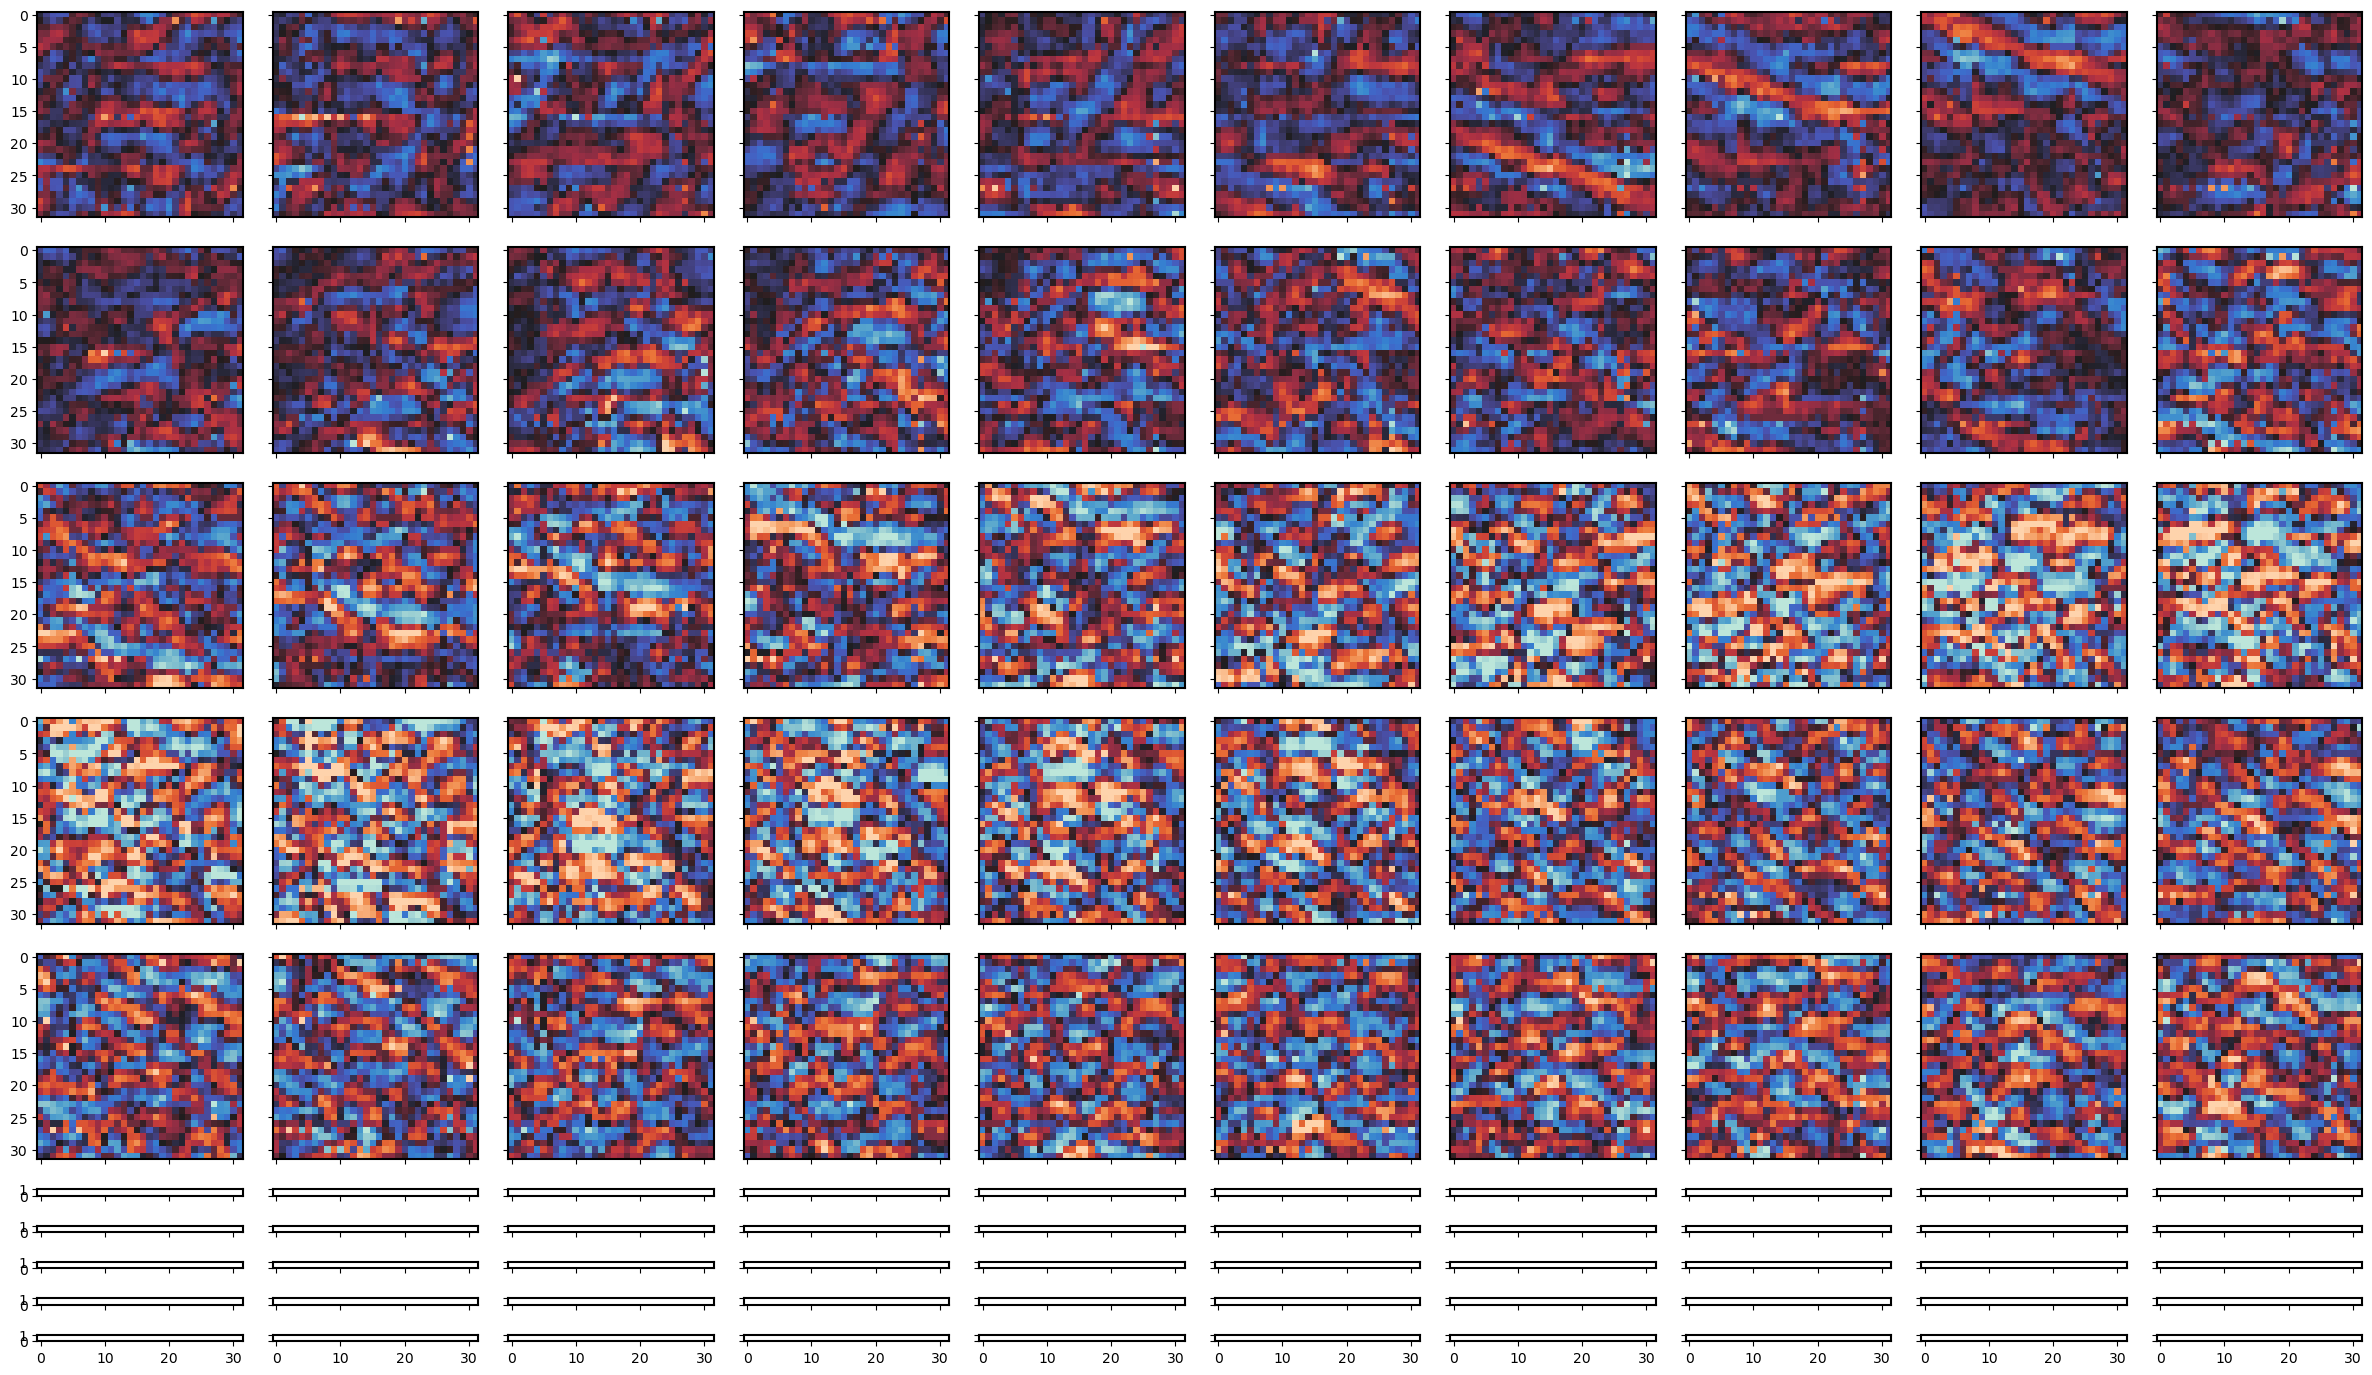

In [257]:
nstack = 1
flat_stacked = flat.reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::100], axis=0) 
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 150)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

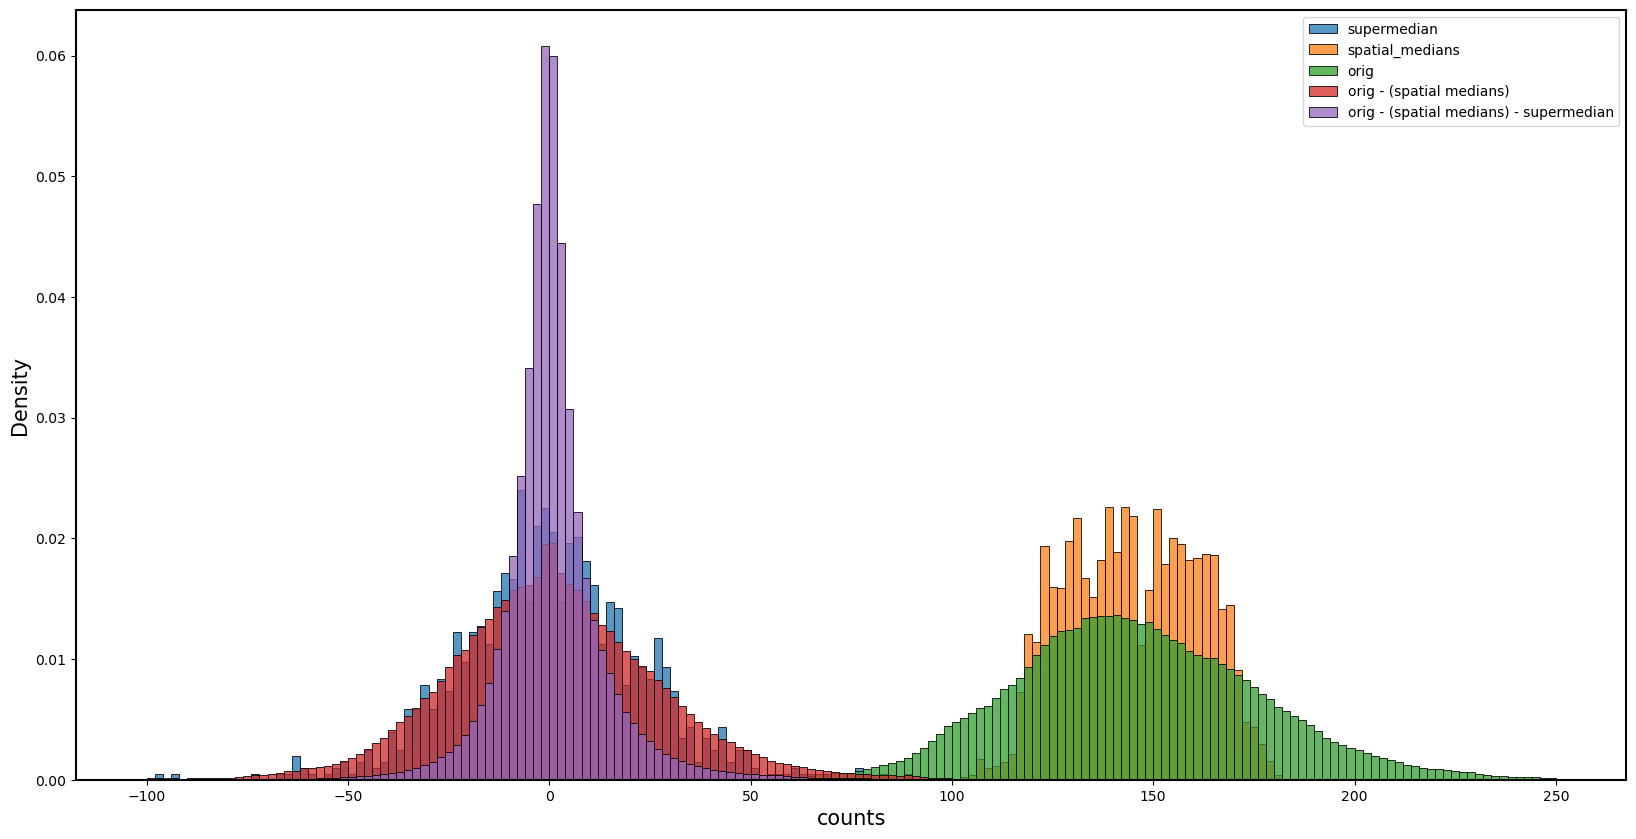

In [253]:
plt.figure(figsize=(20,10))
binrange = [-100, 250]
bins = 175

sm_idxs = np.linspace(0, len(spatial_medians) - 1, 500).astype(int)
bf_idxs = np.linspace(0, len(buffer) - 1, 500).astype(int)
bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 500).astype(int)
flat_idxs = np.linspace(0, len(flat) - 1, 500).astype(int)

sns.histplot(
    supermedian.ravel(), 
    stat='density', 
    label='supermedian', 
    binrange=binrange,
    bins=bins
)
sns.histplot(
    spatial_medians[sm_idxs, :, :].ravel(),
    stat='density',
    label='spatial_medians',
    binrange=binrange,
    bins=bins)
sns.histplot(
    buffer[bf_idxs, :, :].ravel(),
    stat='density',
    label='orig',
    binrange=binrange,
    bins=bins
)
sns.histplot(
    buffer_no_spatial_medians[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians)',
    binrange=binrange, bins=bins
)
sns.histplot(
    flat[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians) - supermedian',
    binrange=binrange,
    bins=bins
)

# sns.histplot(
#     flat_diffs[flat_diff_idxs, :, :].ravel(),
#     stat='density',
#     label='flat diffs',
#     binrange=binrange,
#     bins=bins
# )

# plt.xlim(-100, 100)
plt.xlabel('counts')
plt.legend()